In [1]:
import pandas as pd
import numpy as np
import gzip
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import defaultdict

# CSE 158 Assignment 2

### Issac, Rushi, Ty, Noah

This project analyzes Google Local business data to predict whether a user will review a business. We use exploratory data analysis (EDA) to understand patterns in user behavior, business characteristics, and review distributions. We build and evaluate multiple models, including baseline popularity-based approaches and collaborative filtering, to predict user-business review interactions. The models are evaluated using standard classification metrics (accuracy, precision, recall, F1-score) to identify the most effective approach for this prediction task.

## Table of Contents

- **Data**
- **EDA**
- **Selecting Topics**
- **Modeling**
- **Evaluation**
- **Conclusion**

## Data

We chose to go with the [Google Local Data (2021)](https://mcauleylab.ucsd.edu/public_datasets/gdrive/googlelocal/) because it had a LOT of data. In fact, it had too much data, having millions of data points. Because of this, we decided to filter the data down to businesses in San Diego. We'll begin by importing our data and taking a look at some sample data points.

In [2]:
meta_sd = []
with gzip.open("Data/meta-SanDiego.json.gz", "rt", encoding="utf-8") as f:
    for line in f:
        meta_sd.append(json.loads(line))
        
review_sd = []
for i in range(1, 5):
    with gzip.open(f"Data/review-SanDiego_10_file{i}.json.gz", "rt", encoding="utf-8") as f:
        for line in f:
            review_sd.append(json.loads(line))
            
location_dict = {b['gmap_id']: (b['latitude'],b['longitude']) for b in meta_sd}
review_coords = [location_dict[review_sd[i]['gmap_id']] for i in range(len(review_sd))]
filtered_review_locations = [
    tup for tup in review_coords
    if tup[1] < -116.5
    and tup[0] < 33.8
]

lats = list()
longs = list()
for lat, long in filtered_review_locations:
    lats.append(lat)
    longs.append(long)

In [3]:
meta_sd[0]

{'name': 'HDR',
 'address': 'HDR, 591 Camino De La Reina suite 300, San Diego, CA 92108',
 'gmap_id': '0x80dbffc64011f711:0x6d7970e6968f3f92',
 'description': None,
 'latitude': 32.765555,
 'longitude': -117.16167399999999,
 'category': ['Engineering consultant',
  'Architecture firm',
  'Civil engineering company',
  'Construction company',
  'Environmental engineer'],
 'avg_rating': 5,
 'num_of_reviews': 3,
 'price': None,
 'hours': [['Thursday', '8AM–5PM'],
  ['Friday', '8AM–5PM'],
  ['Saturday', 'Closed'],
  ['Sunday', 'Closed'],
  ['Monday', '8AM–5PM'],
  ['Tuesday', '8AM–5PM'],
  ['Wednesday', '8AM–5PM']],
 'MISC': {'Accessibility': ['Wheelchair accessible entrance']},
 'state': 'Open ⋅ Closes 5PM',
 'relative_results': ['0x80dbff98570bd5a1:0x53a6df3b4d73da85',
  '0x80d9538e0c2e60a7:0xfb635fe02b1e06a7',
  '0x80dc06d36b327ac1:0x39bab4445058dded',
  '0x80dbfe4ca26f4b73:0x1bda90d940f9cbc8',
  '0x80dbffb6cf816d2f:0x25a53967cb9bc656'],
 'url': 'https://www.google.com/maps/place//data=

In [4]:
review_sd[0]

{'user_id': '102919413961325598675',
 'name': 'Humberto Garcia Jr.',
 'time': 1569188767987,
 'rating': 4,
 'text': 'Definitely something worth trying. If you’ve never had Hard Kombucha you need to come here. It’s very different and the inside is beautiful. They have a variety of games and there is plenty of seating.',
 'pics': [{'url': ['https://lh5.googleusercontent.com/p/AF1QipOQvLGEgw3N8Q6ZuF-6-bTuJsJyc5w_hRqhcDmK=w150-h150-k-no-p']},
  {'url': ['https://lh5.googleusercontent.com/p/AF1QipNpJMOyc4I4x1ZtgV8OJ6zEdSyyRO34Y9Ug2GIT=w150-h150-k-no-p']},
  {'url': ['https://lh5.googleusercontent.com/p/AF1QipNbBgiCUpVcEA8yn_ZqpfyTnK5OLxBRyIAdnLA2=w150-h150-k-no-p']},
  {'url': ['https://lh5.googleusercontent.com/p/AF1QipNToM7NgDO_WrCWM0L0sX9kpYIQryoxdEpUP8kT=w150-h150-k-no-p']}],
 'resp': None,
 'gmap_id': '0x80dc7588a897ed91:0x190ac94f6ebb8c76'}

## EDA

#### Spatial Distribution of Reviews

We analyzed the geographic distribution of reviews across San Diego County using a heatmap. The visualization shows review density on a logarithmic scale, with brighter colors indicating higher concentrations. The data reveals a strong concentration along the coastal and central urban areas, with distinct hotspots in densely populated regions. 

This spatial pattern suggests that review activity is closely tied to population density and urban development, which makes sense since more developed areas tend to have more businesses. What's more interesting is the sparse patches between the dense areas which are likely results from zoning for non-commercial areas such as residential/industrial areas.

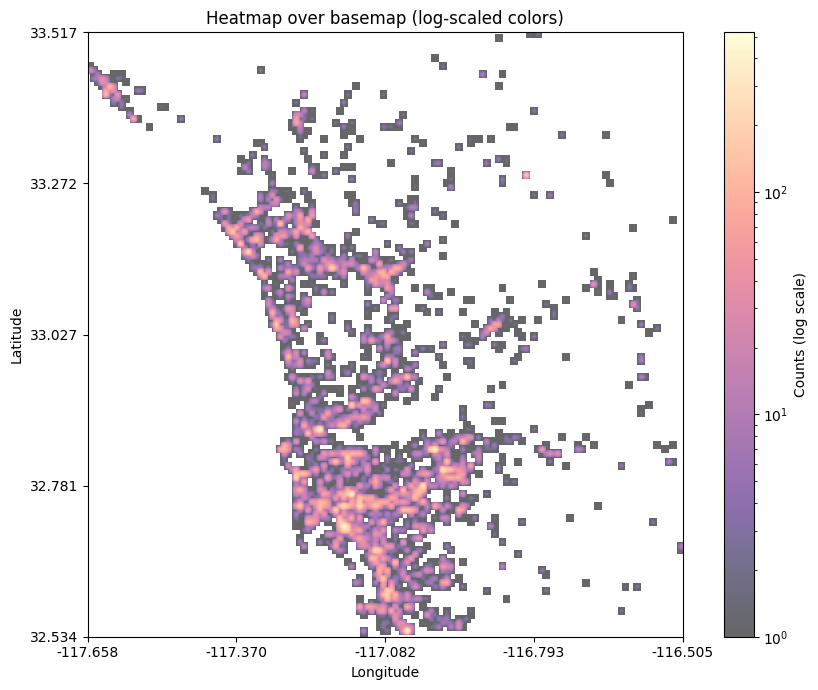

In [5]:
filtered_review_locations = [
    tup for tup in review_coords
    if tup[1] < -116.5
    and tup[0] < 33.8
]

lats = list()
longs = list()
for lat, long in filtered_review_locations:
    lats.append(lat)
    longs.append(long)

lon = np.array(longs)
lat = np.array(lats)

n = len(lon)
if n > 50000:
    idx = np.random.choice(n, size=50000, replace=False)
    lon = lon[idx]; lat = lat[idx]

try:
    import contextily as ctx
    from pyproj import Transformer
    has_ctx = True
except Exception as e:
    has_ctx = False

if has_ctx:
    tf = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    mx, my = tf.transform(lon, lat)
else:
    mx, my = lon, lat

bins = 200 if n <= 50000 else 150
H, xedges, yedges = np.histogram2d(mx, my, bins=bins)

fig, ax = plt.subplots(figsize=(9,7))

if has_ctx:
    zoom = 10
    provider_candidates = [
        'Stamen.TerrainBackground',
        'Stamen.Terrain',
        'Stamen.TonerLite',
        'OpenStreetMap.Mapnik',
        'CartoDB.Positron'
    ]
    img = None
    ext = None
    for pname in provider_candidates:
        prov = None
        try:
            if hasattr(ctx.providers, 'get'):
                prov = ctx.providers.get(pname)
            else:
                prov = ctx.providers[pname]
        except Exception:
            prov = None
        if prov is None:
            continue
        try:
            img, ext = ctx.bounds2img(xedges[0], yedges[0], xedges[-1], yedges[-1], zoom=zoom, source=prov)
            used_provider = pname
            break
        except Exception:
            continue
    if img is None:
        try:
            first_key = list(ctx.providers)[0]
            prov = ctx.providers[first_key]
            img, ext = ctx.bounds2img(xedges[0], yedges[0], xedges[-1], yedges[-1], zoom=zoom, source=prov)
            used_provider = first_key
        except Exception:
            img = None
    if img is not None:
        ax.imshow(img, extent=ext, origin='upper')
        heatmap_extent = ext
    else:
        heatmap_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
else:
    heatmap_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

nonzero = H[H > 0]
if nonzero.size > 0:
    vmin = max(1, nonzero.min())
else:
    vmin = 1
vmax = max(1, H.max())

ax.imshow(H.T, origin='lower', cmap='magma',
          norm=LogNorm(vmin=vmin, vmax=vmax),
          extent=heatmap_extent,
          alpha=0.6, interpolation='bilinear')

if has_ctx:
    inv_tf = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
    mean_my = (yedges[0] + yedges[-1]) / 2
    xticks = np.linspace(xedges[0], xedges[-1], 5)
    try:
        xtick_lons, _ = inv_tf.transform(xticks, np.full_like(xticks, mean_my))
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{v:.3f}" for v in xtick_lons])
    except Exception:
        pass

    mean_mx = (xedges[0] + xedges[-1]) / 2
    yticks = np.linspace(yedges[0], yedges[-1], 5)
    try:
        _, ytick_lats = inv_tf.transform(np.full_like(yticks, mean_mx), yticks)
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{v:.3f}" for v in ytick_lats])
    except Exception:
        pass

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
else:
    ax.set_xlabel('Longitude or X')
    ax.set_ylabel('Latitude or Y')

cb = plt.colorbar(ax.images[-1], ax=ax, label='Counts (log scale)')
ax.set_title('Heatmap over basemap (log-scaled colors)')
plt.tight_layout()

#### Distribution of Review Characteristics

We examined the distributions of review text length and ratings. The review length histogram is right-skewed, with most reviews very short (near 0 characters) and counts dropping sharply as length increases. Few reviews exceed 1000 characters. 

The rating distribution shows a strong positive bias: 5-star ratings are most common (over 700,000), followed by 4-star (around 250,000), with 1–3 stars much less frequent. Another insight is that 2-star reviews are the least common since people tend to have polarized emotions. 

This suggests users tend to leave short reviews and rate businesses highly, which may inform feature engineering and model assumptions.

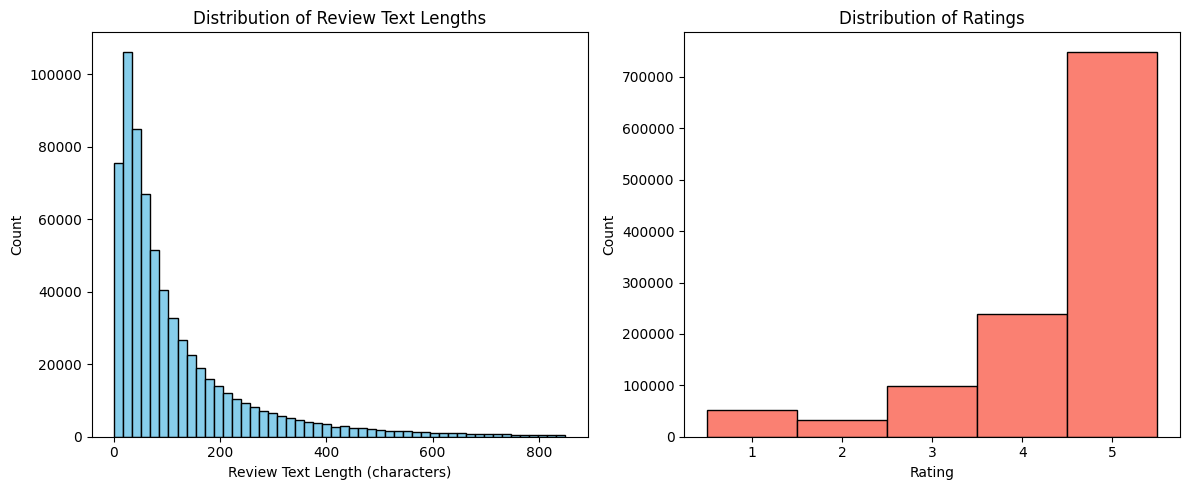

In [6]:
review_lens = [
    len(r.get("text") or "")
    for r in review_sd
]

ratings = [
    int(r.get("rating", 0))
    for r in review_sd
    if r.get("rating") is not None
]

review_lens = np.array(review_lens)
review_lens = review_lens[(review_lens<850) & (review_lens>0)]
ratings = np.array(ratings)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(review_lens, bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Review Text Length (characters)")
plt.ylabel("Count")
plt.title("Distribution of Review Text Lengths")

plt.subplot(1,2,2)
plt.hist(ratings, bins=np.arange(0.5,6.5,1), color="salmon", edgecolor="black")
plt.xticks([1,2,3,4,5])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")

plt.tight_layout()
plt.show()

#### Relationship Between Price Level and Ratings

We analyzed how business price level relates to average ratings. Ratings were normalized to compare across price categories. The results show a positive correlation: lower price levels  tend to have below-average normalized ratings, while higher price levels tend to have above-average normalized ratings.

C:\Users\tyism\AppData\Local\Temp\ipykernel_8308\1729836865.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_stats = df_price.groupby('price')['rating'].agg(['mean','std','count']).reset_index()


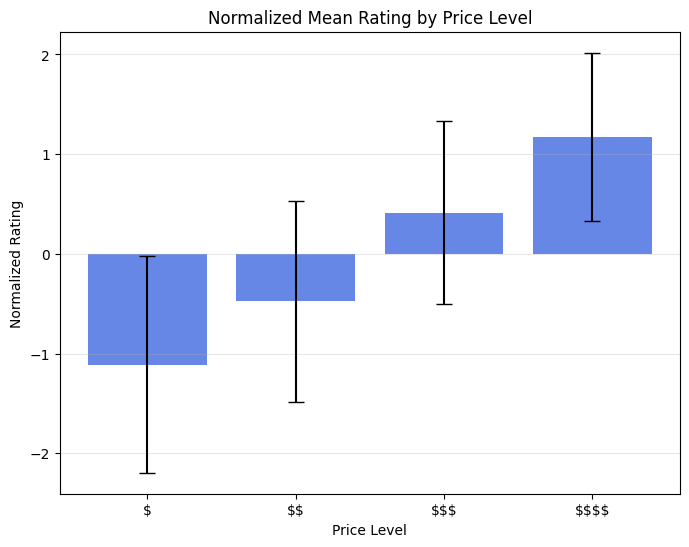

In [7]:
prices = {b['gmap_id']: b['price'] for b in meta_sd if b['price'] != None}

rows = []

for r in review_sd:
    gmap = r['gmap_id']
    rating = r.get('rating')

    if rating is None:
        continue

    price = prices.get(gmap)
    if price in ['$','$$','$$$','$$$$']:
        rows.append({'price': price, 'rating': rating})

df_price = pd.DataFrame(rows)

price_order = ['$', '$$', '$$$', '$$$$']
df_price['price'] = pd.Categorical(df_price['price'], categories=price_order, ordered=True)
df_stats = df_price.groupby('price')['rating'].agg(['mean','std','count']).reset_index()
df_stats['normalized_mean'] = (df_stats['mean'] - df_stats['mean'].mean()) / df_stats['mean'].std()
plt.figure(figsize=(8,6))

plt.bar(
    ['\\$','\\$\\$','\\$\\$\\$','\\$\\$\\$\\$'], 
    df_stats['normalized_mean'],
    yerr=df_stats['std'],
    capsize=6,
    color='royalblue',
    alpha=0.8
)

plt.xlabel("Price Level")
plt.ylabel("Normalized Rating")
plt.title("Normalized Mean Rating by Price Level")
plt.grid(axis='y', alpha=0.3)

plt.show()

#### Significance Between Price Level and Ratings

Next we wanted to see if the relationship we just found is significant or not. In order to do this, we can run a one-way ANOVA as well as a Krusekal-Wallis test to find the significance of this relationship. Doing so reveals that there is in fact a significant relationship. However, the effect size is small with only 0.24\% of the data variance in ratings being explained by price level.

In [8]:
from scipy.stats import f_oneway, kruskal
import numpy as np

price_rating_groups = []
for price_level in ['$', '$$', '$$$', '$$$$']:
    ratings = df_price[df_price['price'] == price_level]['rating'].dropna().tolist()
    if len(ratings) >= 2:
        price_rating_groups.append([float(r) for r in ratings])

print(f"Price levels with sufficient data: {len(price_rating_groups)}")
print(f"Total ratings: {sum(len(g) for g in price_rating_groups)}\n")

print("=" * 60)
print("ONE-WAY ANOVA")
print("=" * 60)
f_stat, p_anova = f_oneway(*price_rating_groups)
print(f"F-statistic: {f_stat:.4f}, P-value: {p_anova:.2e}")

# Calculate eta-squared (effect size for ANOVA)
all_ratings = np.concatenate(price_rating_groups)
grand_mean = np.mean(all_ratings)
ss_between = sum(len(group) * (np.mean(group) - grand_mean)**2 for group in price_rating_groups)
ss_total = sum((rating - grand_mean)**2 for rating in all_ratings)
eta_squared = ss_between / ss_total if ss_total > 0 else 0

print(f"Eta-squared (η²): {eta_squared:.4f}")
print(f"Result: {'Significant' if p_anova < 0.05 else 'Not significant'} (α=0.05)\n")

print("=" * 60)
print("KRUSKAL-WALLIS TEST")
print("=" * 60)
h_stat, p_kw = kruskal(*price_rating_groups)
print(f"H-statistic: {h_stat:.4f}, P-value: {p_kw:.2e}")

# Calculate epsilon-squared (effect size for Kruskal-Wallis)
n_total = sum(len(group) for group in price_rating_groups)
epsilon_squared = (h_stat - (len(price_rating_groups) - 1)) / (n_total - len(price_rating_groups))
epsilon_squared = max(0, epsilon_squared)  # Ensure non-negative

print(f"Epsilon-squared (ε²): {epsilon_squared:.4f}")
print(f"Result: {'Significant' if p_kw < 0.05 else 'Not significant'} (α=0.05)\n")

print("=" * 60)
print("SUMMARY")
print("=" * 60)
if p_anova < 0.05 and p_kw < 0.05:
    print("Both tests: Significant relationship between price level and rating")
    print(f"Effect size (η²): {eta_squared:.4f} - ", end="")
    if eta_squared < 0.01:
        print("Small effect")
    elif eta_squared < 0.06:
        print("Medium effect")
    else:
        print("Large effect")
elif p_anova < 0.05 or p_kw < 0.05:
    print("Mixed results: One test significant")
else:
    print("Both tests: No significant relationship")

Price levels with sufficient data: 4
Total ratings: 536554

ONE-WAY ANOVA
F-statistic: 434.8074, P-value: 3.56e-282
Eta-squared (η²): 0.0024
Result: Significant (α=0.05)

KRUSKAL-WALLIS TEST
H-statistic: 1107.3471, P-value: 9.27e-240
Epsilon-squared (ε²): 0.0021
Result: Significant (α=0.05)

SUMMARY
Both tests: Significant relationship between price level and rating
Effect size (η²): 0.0024 - Small effect


#### Relationship Between Categories and Ratings

Next we wanted to see if the Category variable could potentially explain the variance in rating better. Each business belongs to multiple categories and there end up being ~3000 unique categories. Because of this, we'll only take a look at the 20 most reviewed categories in our bar graph.

In [9]:
categories = {b['gmap_id']: b['category'] for b in meta_sd}

categories_ratings = defaultdict(list)
for r in review_sd:
    cats = categories.get(r['gmap_id'])
    rating = r.get('rating')
    if cats and rating is not None:
        cats_list = cats if isinstance(cats, list) else [cats]
        for cat in cats_list:
            categories_ratings[cat].append(rating)

df_cat = pd.DataFrame([
    {
        'category': cat,
        'weighted_mean': np.array(ratings, dtype=float).mean(),
        'num_reviews': len(ratings)
    }
    for cat, ratings in categories_ratings.items()
]).sort_values('num_reviews', ascending=False)

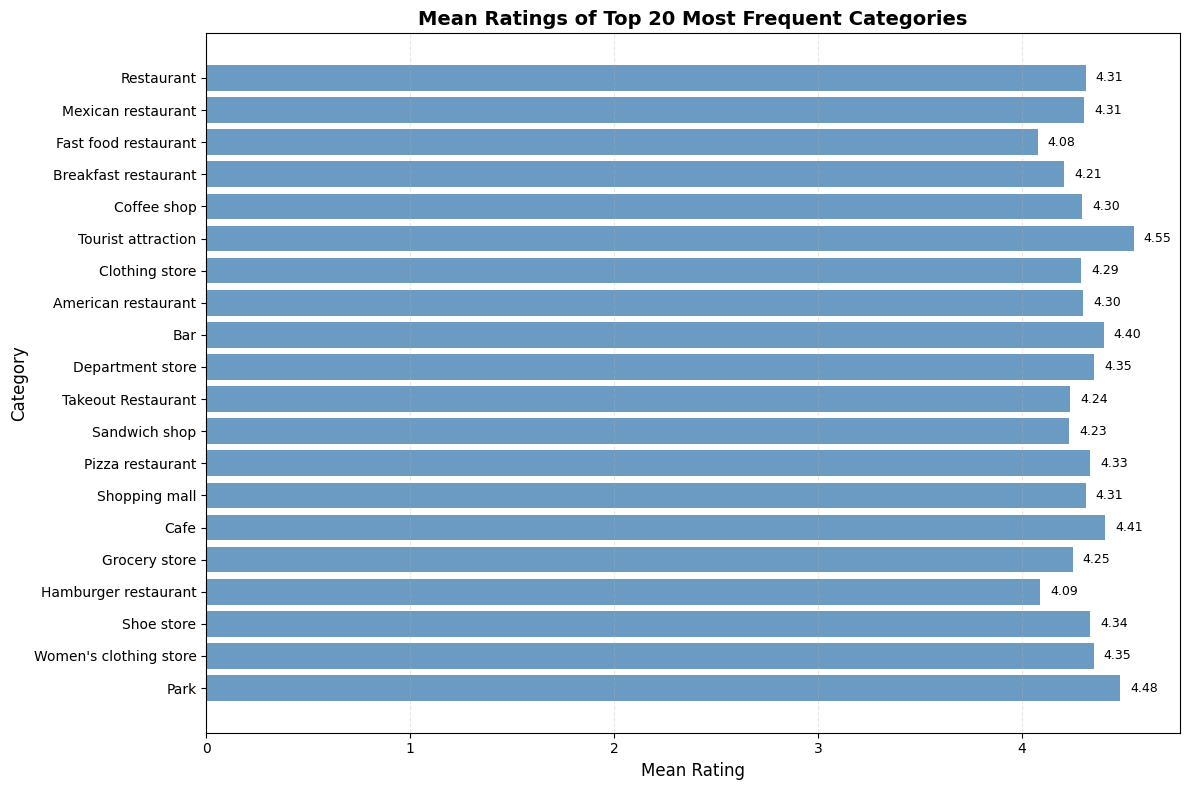

In [10]:
top_20_categories = df_cat.head(20)

# Create bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(
    range(len(top_20_categories)),
    top_20_categories['weighted_mean'],
    color='steelblue',
    alpha=0.8
)

# Set y-axis labels to category names
plt.yticks(range(len(top_20_categories)), top_20_categories['category'])
plt.xlabel('Mean Rating', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.title('Mean Ratings of Top 20 Most Frequent Categories', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (idx, row) in enumerate(top_20_categories.iterrows()):
    plt.text(row['weighted_mean'] + 0.05, i, f"{row['weighted_mean']:.2f}", 
             va='center', fontsize=9)

# Reverse y-axis so highest frequency is at top
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

#### Significance Between Category and Ratings

Again, we can see some variance in mean ratings but we wanted to see if the relationship we just found is significant or not. In order to do this, we can again run a one-way ANOVA as well as a Krusekal-Wallis test to find the significance of this relationship. Doing so reveals that there is in fact a significant relationship. This time, we find a slightly larger effect size at 2.9% indicating that Category is a better predictor of Rating that Price Level.

In [11]:
from scipy.stats import f_oneway, kruskal

category_rating_groups = [
    [float(r) for r in ratings if r is not None]
    for ratings in categories_ratings.values()
    if len([r for r in ratings if r is not None]) >= 2
]

print(f"Categories with sufficient data: {len(category_rating_groups)}")
print(f"Total ratings: {sum(len(g) for g in category_rating_groups)}\n")

print("=" * 60)
print("ONE-WAY ANOVA")
print("=" * 60)
f_stat, p_anova = f_oneway(*category_rating_groups)
print(f"F-statistic: {f_stat:.4f}, P-value: {p_anova:.2e}")

all_ratings = np.concatenate(category_rating_groups)
grand_mean = np.mean(all_ratings)
ss_between = sum(len(group) * (np.mean(group) - grand_mean)**2 for group in category_rating_groups)
ss_total = sum((rating - grand_mean)**2 for rating in all_ratings)
eta_squared = ss_between / ss_total if ss_total > 0 else 0

print(f"Eta-squared (η²): {eta_squared:.4f}")
print(f"Result: {'Significant' if p_anova < 0.05 else 'Not significant'} (α=0.05)\n")

print("=" * 60)
print("KRUSKAL-WALLIS TEST")
print("=" * 60)
h_stat, p_kw = kruskal(*category_rating_groups)
print(f"H-statistic: {h_stat:.4f}, P-value: {p_kw:.2e}")

n_total = sum(len(group) for group in category_rating_groups)
epsilon_squared = (h_stat - (len(category_rating_groups) - 1)) / (n_total - len(category_rating_groups))
epsilon_squared = max(0, epsilon_squared)

print(f"Epsilon-squared (ε²): {epsilon_squared:.4f}")
print(f"Result: {'Significant' if p_kw < 0.05 else 'Not significant'} (α=0.05)\n")

print("=" * 60)
print("SUMMARY")
print("=" * 60)
if p_anova < 0.05 and p_kw < 0.05:
    print("Both tests: Significant relationship between category and rating")
    print(f"Effect size (η²): {eta_squared:.4f} - ", end="")
    if eta_squared < 0.01:
        print("Small effect")
    elif eta_squared < 0.06:
        print("Medium effect")
    else:
        print("Large effect")
elif p_anova < 0.05 or p_kw < 0.05:
    print("Mixed results: One test significant")
else:
    print("Both tests: No significant relationship")

Categories with sufficient data: 2304
Total ratings: 3569821

ONE-WAY ANOVA
F-statistic: 46.1974, P-value: 0.00e+00
Eta-squared (η²): 0.0290
Result: Significant (α=0.05)

KRUSKAL-WALLIS TEST
H-statistic: 108186.5826, P-value: 0.00e+00
Epsilon-squared (ε²): 0.0297
Result: Significant (α=0.05)

SUMMARY
Both tests: Significant relationship between category and rating
Effect size (η²): 0.0290 - Medium effect


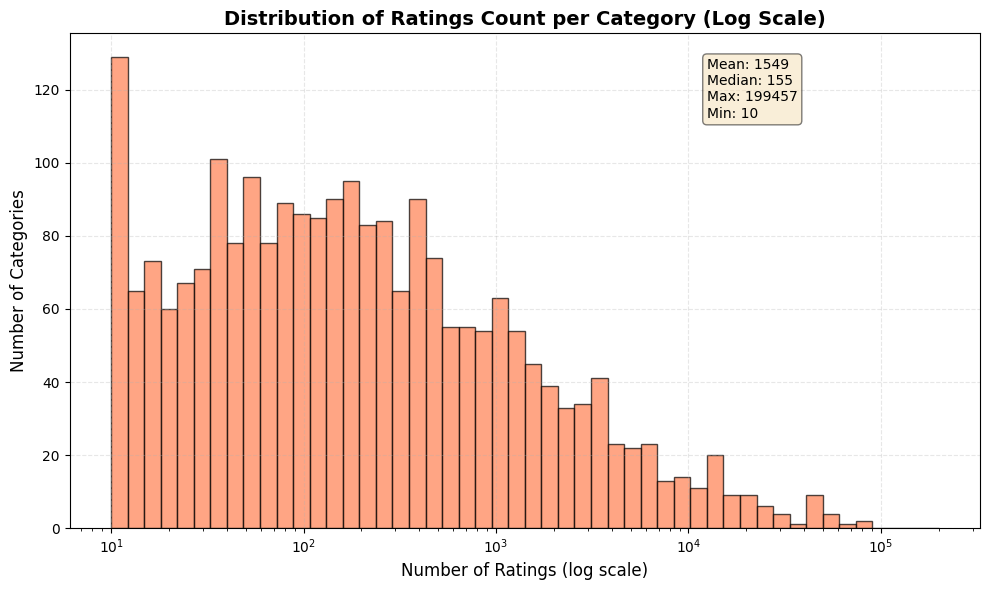

In [12]:
plt.figure(figsize=(10, 6))

min_ratings = df_cat['num_reviews'].min()
max_ratings = df_cat['num_reviews'].max()
log_bins = np.logspace(np.log10(min_ratings), np.log10(max_ratings), 51)

plt.hist(df_cat['num_reviews'], bins=log_bins, color='coral', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Ratings (log scale)', fontsize=12)
plt.ylabel('Number of Categories', fontsize=12)
plt.title('Distribution of Ratings Count per Category (Log Scale)', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.grid(axis='both', alpha=0.3, linestyle='--')

mean_ratings = df_cat['num_reviews'].mean()
median_ratings = df_cat['num_reviews'].median()
stats_text = f'Mean: {mean_ratings:.0f}\nMedian: {median_ratings:.0f}\nMax: {max_ratings:.0f}\nMin: {min_ratings:.0f}'
plt.text(0.7, 0.95, stats_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         fontsize=10)

plt.tight_layout()
plt.show()

#### Filtering Categories

The only issue with categories is the ~3000 unique categories that we would likely need to consider. Ideally, we would be able to only consider the most popular categories which is what the following code does; finds the number of reviews needed to act as a cutoff to find the top 100 most popular categories.

In [13]:
top_k_categories = 100

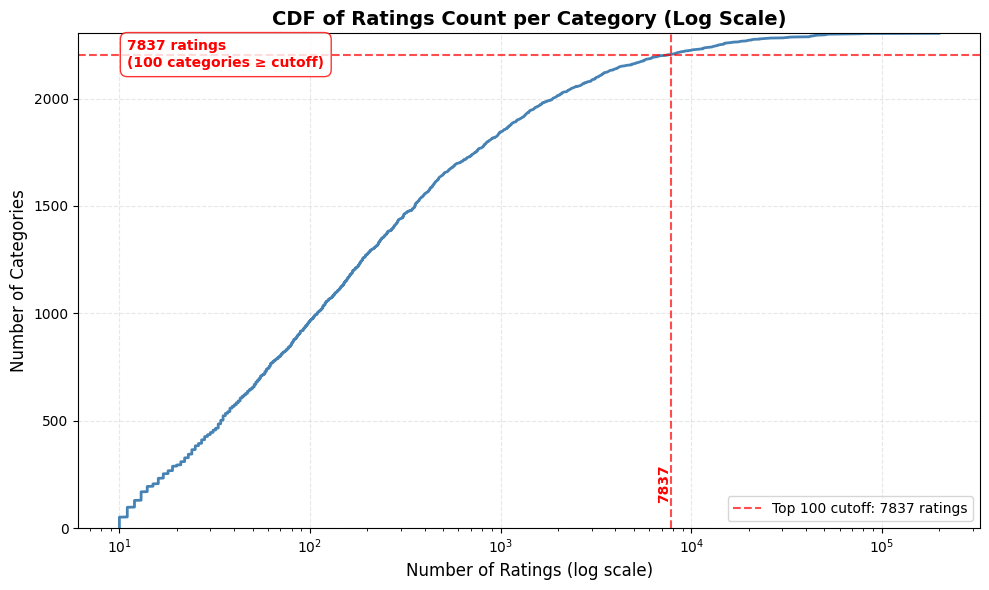

In [14]:
plt.figure(figsize=(10, 6))

sorted_ratings = np.sort(df_cat['num_reviews'])
n = len(sorted_ratings)
k = max(1, min(int(top_k_categories), n))
cumulative_count = np.arange(1, n + 1)

plt.plot(sorted_ratings, cumulative_count, linewidth=2, color='steelblue')
plt.xlabel('Number of Ratings (log scale)', fontsize=12)
plt.ylabel('Number of Categories', fontsize=12)
plt.title('CDF of Ratings Count per Category (Log Scale)', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.grid(axis='both', alpha=0.3, linestyle='--')
plt.ylim(0, n)

cutoff_idx = max(0, n - k)
cutoff_value = sorted_ratings[cutoff_idx]
cutoff_count = cumulative_count[cutoff_idx]
categories_at_or_above = n - cutoff_idx

cutoff_label = f'Top {k} cutoff: {cutoff_value:.0f} ratings'
plt.axvline(cutoff_value, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=cutoff_label)
plt.axhline(cutoff_count, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

plt.text(cutoff_value, n * 0.05, f'{cutoff_value:.0f}',
         rotation=90, verticalalignment='bottom', horizontalalignment='right',
         fontsize=10, color='red', fontweight='bold')

plt.text(sorted_ratings[0] * 1.1, cutoff_count,
         f'{cutoff_value:.0f} ratings\n({categories_at_or_above} categories ≥ cutoff)',
         verticalalignment='center', horizontalalignment='left',
         fontsize=10, color='red', fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='red'))

plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()

## Selecting a Topic

As you can see from our EDA, we were initially leaning towards predicting ratings from the metadata about the businesses and review data. However, we ended up deciding on pursuing a different prediction model where we would predict if a user would review a business or not. The main reason we switched topics is because we figured that predicting ratings was too common of a task and we wanted to something a bit more unique. Luckily, the EDA that we conducted gave us some good insights on what to consider when tackling our new chosen problem.

## Modeling

### Data Setup

Before creating the baseline and collaborative filtering models, we need to set up the data.

In [2]:
import random
from collections import defaultdict

# create validation set
def create_validation_set(reviews, meta, val_size=10000):
    random.seed(14)

    all_users = list(set(rev["user_id"] for rev in reviews))

    sampled_users = random.sample(all_users, val_size)

    reviews_valid = [rev for rev in reviews if rev["user_id"] in sampled_users]

    businesses_valid = set(rev["gmap_id"] for rev in reviews_valid)

    meta_valid = {business_id: meta[business_id] for business_id in businesses_valid if business_id in meta}

    return reviews_valid, meta_valid

# generate positive/negative samples for model training
def generate_samples(reviews, meta):
    random.seed(14)

    user_businesses = defaultdict(set)
    all_businesses = set()

    for rev in reviews:
        user_id = rev['user_id']
        business_id = rev['gmap_id']
        user_businesses[user_id].add(business_id)
        all_businesses.add(business_id)

    pos = []
    neg = []

    for user_id, reviewed_businesses in user_businesses.items():
        # pos samples (businesses the user has reviewed)
        for business_id in reviewed_businesses:
            pos.append((user_id, business_id))

        # neg samples (businesses the user has not reviewed)
        unreviewed_businesses = list(all_businesses - reviewed_businesses)

        n_neg = len(reviewed_businesses)
        sampled_negs = random.sample(unreviewed_businesses, n_neg)

        for business_id in sampled_negs:
            neg.append((user_id, business_id))
    
    return pos, neg

# split data into train/test sets
def train_test_split(pos, neg, test_size=0.2):
    random.seed(14)

    all_samples = [(user, business, 1) for user, business in pos] + [(user, business, 0) for user, business in neg]

    random.shuffle(all_samples)

    split_index = int(len(all_samples) * (1 - test_size))
    train_samples = all_samples[:split_index]
    test_samples = all_samples[split_index:]

    return train_samples, test_samples

Then, run the code below:

In [5]:
import json
import gzip
from collections import defaultdict

reviews = []

for file in ["Data/review-SanDiego_10_file1.json.gz", "Data/review-SanDiego_10_file2.json.gz", 
             "Data/review-SanDiego_10_file3.json.gz", "Data/review-SanDiego_10_file4.json.gz"]:
    with gzip.open(file, 'rt', encoding='utf-8') as f:
        for line in f:
            reviews.append(json.loads(line))

meta = {}

with gzip.open("Data/meta-SanDiego.json.gz", 'rt', encoding='utf-8') as f:
    for line in f:
        business = json.loads(line)
        meta[business['gmap_id']] = business

In [6]:
reviews_valid, meta_valid = create_validation_set(reviews, meta, val_size=1000)

pos, neg  = generate_samples(reviews_valid, meta_valid)

train_samples, test_samples = train_test_split(pos, neg, test_size=0.2)

user_businesses = defaultdict(set)

for rev in reviews_valid:
    user_id = rev['user_id']
    business_id = rev['gmap_id']
    user_businesses[user_id].add(business_id)

### Baseline Model

#### Model Overview
This is a simple model that predicts whether a user will review a business based on the popularity
of that business. What the model does is it counts the number of positive reviews in the training set.
Then, it ranks the businesses by their review counts and predicts "yes" if the business is one of the 
top 50% most popular businesses.

First, `baseline_model()` makes a sorted list of businesses based on number of reviews. Then, 
`baseline_predict()` makes a set of the top 50% most popular businesses. Finally,
`evaluate_baseline_model` predicts yes if a business is in the set of top 50% of business, and no
otherwise. The function then calculates the accuracy, precision, recall, and f1 score of the model.

In [7]:
# build baseline model
def baseline_model(train_samples):
    business_popularity = defaultdict(int)

    for user_id, business_id, label in train_samples:
        if label == 1:
            business_popularity[business_id] += 1

    sorted_businesses = [(count, business_id) for business_id, count in business_popularity.items()]
    sorted_businesses.sort(reverse=True)

    return sorted_businesses

# predict yes for top 50% popular businesses
def baseline_predict(sorted_businesses, total_reviews, thresh=0.5):
    topFifty = set()
    cum_revs = 0
    threshold_reviews = total_reviews * thresh

    for count, business_id in sorted_businesses:
        topFifty.add(business_id)
        cum_revs += count

        if cum_revs >= threshold_reviews:
            break

    return topFifty

def evaluate_baseline_model(test_samples, topFifty):
    TP = FP = TN = FN = 0

    for user_id, business_id, label in test_samples:
        pred = 1 if business_id in topFifty else 0

        if label == 1 and pred == 1:
            TP += 1
        elif label == 1 and pred == 0:
            FN += 1
        elif label == 0 and pred == 1:
            FP += 1
        elif label == 0 and pred == 0:
            TN += 1
        
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

Then, run the code below to build and test the model:

In [9]:
sorted_businesses = model.baseline_model(train_samples)
total_revs = sum(count for count, business_id in sorted_businesses)
baseline_preds = model.baseline_predict(sorted_businesses, total_revs)
results = model.evaluate_baseline_model(test_samples, baseline_preds)
results

{'accuracy': 0.4872881355932203,
 'precision': 0.487758945386064,
 'recall': 0.24070631970260223,
 'f1_score': 0.32233976353453636}

#### Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract counts
cm = results["confusion_matrix"]
TP, FP, FN, TN = cm["TP"], cm["FP"], cm["FN"], cm["TN"]

matrix = np.array([[TN, FP],
                   [FN, TP]])

# Use metrics *directly from results* (DO NOT recompute)
accuracy  = results["accuracy"]
precision = results["precision"]
recall    = results["recall"]
f1        = results["f1_score"]

# Plot
fig, ax = plt.subplots(figsize=(9, 5))

im = ax.imshow(matrix, cmap="Blues")

# Annotate values (white text for Pred 0 column)
for i in range(2):
    for j in range(2):
        value = matrix[i, j]
        text_color = "white" if j == 0 else "black"
        ax.text(j, i, value,
                ha="center", va="center",
                color=text_color,
                fontsize=14)

# Axis labels
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(["Pred 0", "Pred 1"])
ax.set_yticklabels(["Actual 0", "Actual 1"])

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix (Baseline Model)")

# Add colorbar
plt.colorbar(im, ax=ax)

# Metrics box (no overlap)
metrics_text = (
    f"Accuracy : {accuracy:.4f}\n"
    f"Precision: {precision:.4f}\n"
    f"Recall   : {recall:.4f}\n"
    f"F1 Score : {f1:.4f}"
)

plt.gcf().text(
    0.97, 0.50,
    metrics_text,
    fontsize=12,
    va="center",
    color="black",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5")
)

plt.tight_layout()
plt.show()


### Collaborative Filtering Model


#### Model Overview
This model improves on the baseline model by making predictions based on users with similar review patterns.
The model uses Jaccard similarity to measure how similar two users are based on the businesses they've reviewed.
It predicts if a user will review a business if similar users have reviewed it.

First, `jaccard_similarity()` calculates the similarity of two users by getting the ratio of the businesses
that they've both reviewed out of total reviews. Then, `find_similar_users()` finds the k=20 most similar
users using the Jaccard Similarity. Finally, `collaborative_filtering_predict()` for each (user, business)
pair, the function gets the most similar users and predicts "yes" if at least 1 similar users has reviewed 
that business. 

In [11]:
def jaccard_similarity(set1, set2):
    # compute jaccard sim
    if not set1 or not set2:
        return 0
    
    numer = len(set1.intersection(set2))
    denom = len(set1.union(set2))

    if denom > 0:
        return numer/denom
    return 0

def find_similar_users(user_id, user_businesses, k=10):
    # get k most similar users based on reviewed businesses
    target_businesses = user_businesses.get(user_id, set())
    if not target_businesses:
        return []
    
    similarities = []
    for other_user, other_businesses in user_businesses.items():
        if other_user == user_id:
            continue
        
        sim = jaccard_similarity(target_businesses, other_businesses)
        if sim > 0:
            similarities.append((sim, other_user))
    
    similarities.sort(reverse=True)
    return similarities[:k]


def collaborative_filtering_predict(test_samples, user_businesses, 
                                   similarity_threshold=0.01, 
                                   min_similar_reviews=1):
    # predicts yes if similar users have reviewed the business
    predictions = set()
    
    for user_id, business_id, _ in test_samples:
        # get similar users
        similar_users = find_similar_users(user_id, user_businesses, k=20)
        
        # count num similar users who reviewed the business
        similar_review_count = 0
        for sim_score, similar_user in similar_users:
            # low threshold -> keep max num similar users
            if sim_score < similarity_threshold:
                break
            
            if business_id in user_businesses.get(similar_user, set()):
                similar_review_count += 1
        
        # predict yes if enough similar users reviewed the business
        if similar_review_count >= min_similar_reviews:
            predictions.add((user_id, business_id))
    
    return predictions

def evaluate_filtering_model(test_samples, predictions):
    # evaluate model
    TP = FP = TN = FN = 0
    
    for user_id, business_id, label in test_samples:
        pred = 1 if (user_id, business_id) in predictions else 0
        
        if label == 1 and pred == 1:
            TP += 1
        elif label == 1 and pred == 0:
            FN += 1
        elif label == 0 and pred == 1:
            FP += 1
        elif label == 0 and pred == 0:
            TN += 1
    
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }


Then, run the code below to build and evaluate the model:

In [12]:
preds_collab = model.collaborative_filtering_predict(test_samples, user_businesses, similarity_threshold=0.01)
results_collab = model.evaluate_filtering_model(test_samples, preds_collab)
print("Collaborative filtering:", results_collab)

Collaborative filtering: {'accuracy': 0.6732580037664784, 'precision': 0.9282511210762332, 'recall': 0.3847583643122677, 'f1_score': 0.5440210249671485}


#### Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Extract counts
cm = results["confusion_matrix"]
TP, FP, FN, TN = cm["TP"], cm["FP"], cm["FN"], cm["TN"]

matrix = np.array([[TN, FP],
                   [FN, TP]])

# Compute metrics
y_true = np.array([label for (_,_,label) in test_samples])
y_pred = np.array([(u,b) in baseline_preds for (u,b,_) in test_samples]).astype(int)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)

# Plot
fig, ax = plt.subplots(figsize=(9, 5))

im = ax.imshow(matrix, cmap="Blues")

# Annotate values with conditional white text (TN & FN)
for i in range(2):
    for j in range(2):
        value = matrix[i, j]
        
        # Make BOTH cells in Pred 0 column white (TN and FN)
        text_color = "white" if j == 0 else "black"

        ax.text(j, i, value,
                ha="center", va="center",
                color=text_color,
                fontsize=14)

# Axis labels
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(["Pred 0", "Pred 1"])
ax.set_yticklabels(["Actual 0", "Actual 1"])

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix (Collaborative Filtering)")

# Add colorbar
plt.colorbar(im, ax=ax)


# ---- Metrics box ----
metrics_text = (
    f"Accuracy : {accuracy:.4f}\n"
    f"Precision: {precision:.4f}\n"
    f"Recall   : {recall:.4f}\n"
    f"F1 Score : {f1:.4f}"
)

# Place metrics box far right (no overlap)
plt.gcf().text(
    0.97, 0.50,
    metrics_text,
    fontsize=12,
    va="center",
    color="black",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5")
)

plt.tight_layout()
plt.show()


### Random Forest Model


#### Model Overview

This model uses a **feature-based supervised learning approach** to predict whether a user will review a business. Instead of depending on popularity or user overlap, it builds a rich feature vector for each `(user, business)` pair. Business attributes include `latitude`, `longitude`, `avg_rating`, `num_reviews`, `price`, and a one-hot encoded `category` vector. User attributes include `num_reviews`, `avg_rating`, inferred `home_lat`/`home_lon`, and normalized `cat_pref`. It also incorporates cross-user/business features such as geographic distance (computed with `fast_haversine()`) and a category-match score.

These features are combined in `fast_make_matrix()` and used to train a `RandomForestClassifier` on positive review pairs and sampled negative pairs. The model learns complex patterns that signal whether a user is likely to interact with a business. After training, predictions are evaluated using standard metrics (`accuracy`, `precision`, `recall`, `f1`) along with a full confusion matrix, providing a stronger and more expressive alternative to the baseline and collaborative filtering models.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict, Counter
import math
import random

TOP_K_CATEGORIES = 100
NEG_POS_RATIO = 1.0
random.seed(42)
np.random.seed(42)

reviews_train, reviews_test = train_test_split(
    reviews,
    test_size=0.2,
    random_state=42
)

all_categories = []
for biz_id, biz in meta.items():
    for cat in (biz.get("category") or []):
        all_categories.append(cat.strip().lower())

cat_counts = Counter(all_categories)
top_categories = [cat for cat, _ in cat_counts.most_common(TOP_K_CATEGORIES)]
category_to_idx = {cat: i for i, cat in enumerate(top_categories)}

def price_to_num(price):
    if price == "$": return 1
    if price == "$$": return 2
    if price == "$$$": return 3
    if price == "$$$$": return 4
    return 0

business_features = {}
for biz_id, biz in meta.items():
    cat_vec = np.zeros(TOP_K_CATEGORIES, dtype=np.float32)
    for cat in (biz.get("category") or []):
        low = cat.lower()
        if low in category_to_idx:
            cat_vec[category_to_idx[low]] = 1
    business_features[biz_id] = {
        "lat": float(biz["latitude"]),
        "lon": float(biz["longitude"]),
        "avg_rating": float(biz.get("avg_rating", 0) or 0),
        "num_reviews": float(biz.get("num_of_reviews", 0) or 0),
        "price": float(price_to_num(biz.get("price"))),
        "cat_vec": cat_vec
    }

user_profiles = {}
for rev in reviews_train:
    uid = rev["user_id"]
    biz_id = rev["gmap_id"]
    rating = rev.get("rating")
    if uid not in user_profiles:
        user_profiles[uid] = {
            "num_reviews": 0,
            "sum_ratings": 0,
            "lat_sum": 0.0,
            "lon_sum": 0.0,
            "cat_pref": np.zeros(TOP_K_CATEGORIES, dtype=np.float32)
        }
    prof = user_profiles[uid]
    prof["num_reviews"] += 1
    if rating is not None:
        prof["sum_ratings"] += rating
    biz = meta.get(biz_id)
    if biz:
        prof["lat_sum"] += biz["latitude"]
        prof["lon_sum"] += biz["longitude"]
        for cat in (biz.get("category") or []):
            low = cat.lower()
            if low in category_to_idx:
                prof["cat_pref"][category_to_idx[low]] += 1

for uid, prof in user_profiles.items():
    n = prof["num_reviews"]
    prof["avg_rating"] = prof["sum_ratings"] / n if n else 0
    prof["home_lat"]  = prof["lat_sum"] / n if n else 0
    prof["home_lon"]  = prof["lon_sum"] / n if n else 0
    total = prof["cat_pref"].sum()
    if total > 0:
        prof["cat_pref"] = prof["cat_pref"] / total

def fast_haversine(lat1, lon1, lat2, lon2):
    lat1 = np.radians(lat1); lon1 = np.radians(lon1)
    lat2 = np.radians(lat2); lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 6371 * 2 * np.arcsin(np.sqrt(a))

def create_pairs(reviews_split, label):
    return [(r["user_id"], r["gmap_id"], label) for r in reviews_split]

pos_train = create_pairs(reviews_train, 1)
pos_test  = create_pairs(reviews_test, 1)

all_users_train = list({u for u,_,_ in pos_train})
all_users_test  = list({u for u,_,_ in pos_test})
all_biz_ids     = list(meta.keys())

def fast_negative_sampling(users, n_pos):
    n_neg = int(n_pos * NEG_POS_RATIO)
    sampled_users = np.random.choice(users, size=n_neg)
    sampled_biz   = np.random.choice(all_biz_ids, size=n_neg)
    return list(zip(sampled_users, sampled_biz, np.zeros(n_neg, dtype=np.int8)))

neg_train = fast_negative_sampling(all_users_train, len(pos_train))
neg_test  = fast_negative_sampling(all_users_test,  len(pos_test))

train_pairs = pos_train + neg_train
test_pairs  = pos_test  + neg_test

biz_ids = list(business_features.keys())
biz_index = {bid: i for i, bid in enumerate(biz_ids)}

user_ids = list(user_profiles.keys())
user_index = {uid: i for i, uid in enumerate(user_ids)}

biz_matrix = np.zeros((len(biz_ids), 5 + TOP_K_CATEGORIES), dtype=np.float32)
for i, bid in enumerate(biz_ids):
    bf = business_features[bid]
    biz_matrix[i, 0:5] = np.array([bf["lat"], bf["lon"], bf["avg_rating"], bf["num_reviews"], bf["price"]])
    biz_matrix[i, 5:]  = bf["cat_vec"]

user_matrix = np.zeros((len(user_ids), 2 + TOP_K_CATEGORIES + 2), dtype=np.float32)
for i, uid in enumerate(user_ids):
    uf = user_profiles[uid]
    user_matrix[i, 0:2] = np.array([uf["num_reviews"], uf["avg_rating"]])
    user_matrix[i, 2:2+TOP_K_CATEGORIES] = uf["cat_pref"]
    user_matrix[i, 2+TOP_K_CATEGORIES:2+TOP_K_CATEGORIES+2] = np.array([uf["home_lat"], uf["home_lon"]])

FEATURE_DIM = 5 + TOP_K_CATEGORIES + 2 + TOP_K_CATEGORIES + 2

def fast_make_matrix(pairs):
    pair_users  = np.array([u for (u,_,_) in pairs])
    pair_bizs   = np.array([b for (_,b,_) in pairs])
    pair_labels = np.array([y for (_,_,y) in pairs], dtype=np.int8)
    u_idx = np.array([user_index.get(u, -1) for u in pair_users])
    b_idx = np.array([biz_index[b] for b in pair_bizs])
    b_block = biz_matrix[b_idx]
    u_block = user_matrix[u_idx]
    u_cats = u_block[:, 2:2+TOP_K_CATEGORIES]
    b_cats = b_block[:, 5:5+TOP_K_CATEGORIES]
    dists = fast_haversine(
        u_block[:, 2+TOP_K_CATEGORIES], 
        u_block[:, 3+TOP_K_CATEGORIES],
        b_block[:, 0],
        b_block[:, 1]
    )
    cat_match = np.sum(u_cats * b_cats, axis=1)
    X = np.concatenate([
        b_block,
        u_block[:, :2],
        u_cats,
        dists[:, None],
        cat_match[:, None]
    ], axis=1)
    return X.astype(np.float32), pair_labels

print("Building X_train...")
X_train, y_train = fast_make_matrix(train_pairs)

print("Building X_test...")
X_test, y_test = fast_make_matrix(test_pairs)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

probs = rf.predict_proba(X_test)[:, 1]
preds = (probs >= 0.5).astype(int)

tp = np.sum((preds == 1) & (y_test == 1))
fp = np.sum((preds == 1) & (y_test == 0))
fn = np.sum((preds == 0) & (y_test == 1))
tn = np.sum((preds == 0) & (y_test == 0))

precision = tp / (tp + fp + 1e-10)
recall = tp / (tp + fn + 1e-10)
f1 = 2 * precision * recall / (precision + recall + 1e-10)
accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-10)

print({
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1": float(f1),
    "tp": int(tp),
    "fp": int(fp),
    "fn": int(fn),
    "tn": int(tn),
    "support": len(y_test)
})


#### Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Confusion matrix
cm = confusion_matrix(y_test, preds)

# Metrics
accuracy  = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, zero_division=0)
recall    = recall_score(y_test, preds, zero_division=0)
f1        = f1_score(y_test, preds, zero_division=0)

# Plot
fig, ax = plt.subplots(figsize=(9, 5))  # slightly wider to fit the box

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"],
    ax=ax
)

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix (LightGBM)")

# ---- Metrics box ----
metrics_text = (
    f"Accuracy : {accuracy:.4f}\n"
    f"Precision: {precision:.4f}\n"
    f"Recall   : {recall:.4f}\n"
    f"F1 Score : {f1:.4f}"
)

# Move textbox FAR to the right to avoid the colorbar
plt.gcf().text(
    0.97, 0.5, metrics_text,
    fontsize=12,
    va="center",
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5")
)

plt.tight_layout()
plt.show()


## Evaluation

## Conclusion

The Google Local Reviews dataset and its variants have been widely used in research on recommender systems, user modeling, and multimodal learning. Prior work using this dataset has focused primarily on understanding how users interact with businesses through reviews, and how text, images, and metadata can be leveraged to improve recommendations and explanations. For example, Li, Shang, and McAuley in 2022 introduced UCTopic, a framework that uses contrastive learning to extract high-quality phrase representations from review text, enabling improved topic mining and downstream recommendation tasks. Similarly, Yan et al, also in 2022, used the dataset to develop multimodal explanation models that combine images, text, and metadata to justify recommendations and increase transparency.

Although prior work often focuses on rating prediction, topic modeling, or explanation generation, many studies in the recommendation systems literature have approached tasks similar to ours, predicting whether a user will engage with a particular item. This formulation is typically known as binary implicit feedback modeling, where the presence of an interaction (such as a review, click, or purchase) is treated as a positive signal and the absence of one is treated as a negative or unknown signal. Classic approaches include popularity baselines, neighborhood-based collaborative filtering (using cosine or Jaccard similarity), and more recently, matrix factorization or neural methods (like BPR, LightFM, and graph-based recommenders). Our modeling approach was treating user reviews as implicit feedback and generating negative samples by selecting businesses the user has not reviewed. This is directly aligned with this line of work.

Our results closely match patterns seen in the literature. The popularity baseline performs poorly for personalized prediction tasks, which is consistent with findings that global popularity cannot capture user-specific preferences. In contrast, our user-user collaborative filtering model significantly improves performance, particularly in precision, mirroring decades of work showing that neighborhood-based collaborative filtering is an effective method when user histories are meaningful and overlap is sufficient. The high precision but moderate recall we observe is also commonly reported in related studies: neighborhood methods are conservative and tend to make correct but selective predictions, whereas more advanced methods (for example: matrix factorization, neural recommenders, graph convolutional models) typically improve recall by generalizing beyond explicit overlap.

Unlike some prior work using this dataset, our focus is not on multimodal modeling or text-based prediction, but rather on pure behavioral similarity through user interactions. Nonetheless, the strong performance of collaborative filtering aligns with the broader findings in the field that user–user similarity remains a powerful baseline and often outperforms naive popularity models. Our results differ from multimodal and text-based studies in that we do not incorporate semantic information such as review content, images, or business attributes. However, this also highlights an opportunity for future work: incorporating metadata or textual embeddings could help address the recall limitations of purely behavioral collaborative filtering, potentially bringing our results closer to those reported in more expressive models.